<a href="https://colab.research.google.com/github/artiboi2002/dp-poisoning-attacks/blob/main/Experiment_3_Clean_Model_With_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from opacus import PrivacyEngine
import time

transform = transforms.ToTensor() #converting MNIST Image into tensor of 4 dimensions(image, height, wdith, color channel)
#Train Data
trainData = datasets.MNIST(root ='/cnn_data', train = True, download = True, transform = transform)
#Test Data
testData = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

In [2]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2,2) #2x2 kernal and a stride of 2
    x = F.relu(self.conv2(x)) #1 image, 6 output, 3 kernal, 1 stride
    x = F.max_pool2d(x, 2, 2)

    #Review to flatten in out
    x = x.view(-1, 16*5*5)

    #Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim = 1)

In [3]:
def trainingFunction(model, train_loader,test_loader, epochs, criterion, optimizer):
  train_loss = []
  test_loss = []
  train_correct =[]
  test_correct = []

 #For loop of Epochs
  for i in range(epochs):
    train_corr = 0
    test_corr = 0
    total_samples = 0
    test_total_samples = 0


  #Train
    for b,(X_train, Y_train) in enumerate(train_loader):
      b += 1 #start our batches at 1
      y_pred = model(X_train) #get the predicted values from the training set. Not flaattedned 2D
      loss = criterion(y_pred, Y_train) #How off are we? Compare the prediction to the correct answers in Y_train
      predicted = torch.max(y_pred.data, 1)[1] #we want to add up the correct number of prediciton. Indexed of the first point
      batch_corr = (predicted == Y_train).sum() #we want to know how many we got correct.
      train_corr += batch_corr #keep track as we go aloing in training
      total_samples += Y_train.size(0)

    #Update the parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if b % 1000 == 0:
        print(f'Epoch: {i+1}, Batch {b}, Loss {loss.item(): .4f}')

  #append train loss and train correct into the list
    train_loss.append(loss.item())
    train_correct.append(train_corr.item())

  #Test
    with torch.no_grad():
      for b,(X_test, Y_test) in enumerate(test_loader):
        y_value = model(X_test)
        loss = criterion(y_value, Y_test)
        predicted = torch.max(y_value.data, 1)[1]
        test_corr += (predicted == Y_test).sum()
        test_total_samples += Y_test.size(0)

 #append test loss and train correct into the list
    test_loss.append(loss.item())
    test_correct.append(test_corr.item())
    train_accuracy = 100 * train_corr.item() / total_samples
    test_accuracy = 100 * test_corr.item() / test_total_samples
    print(f"Epoch {i + 1} — Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {i + 1} — Test Accuracy: {test_accuracy:.2f}%")


  return train_loss, test_loss, train_correct, test_correct

In [4]:
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) #Smaller the learning rate the longer is gonna take to train
trainLoader = DataLoader(trainData, batch_size=32, shuffle = True)
testLoader = DataLoader(testData, batch_size=32, shuffle = False)
epochs = 30

#Adding differnetial privacy before training
privacy = PrivacyEngine()
model, optimizer, trainLoader = privacy.make_private_with_epsilon(module = model, optimizer = optimizer, data_loader= trainLoader,
    target_epsilon=1.0, target_delta=1e-5, epochs=30, max_grad_norm=1.0)

train_loss, test_loss, train_correct, test_correct = trainingFunction(
    model, trainLoader, testLoader, epochs, criterion, optimizer
)

epsilon = privacy.get_epsilon(delta=1e-5)
print(f"Final ε after training: {epsilon:.2f}")


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch: 1, Batch 1000, Loss  2.2503
Epoch 1 — Train Accuracy: 35.52%
Epoch 1 — Test Accuracy: 59.46%
Epoch: 2, Batch 1000, Loss  1.4046
Epoch 2 — Train Accuracy: 61.90%
Epoch 2 — Test Accuracy: 66.17%
Epoch: 3, Batch 1000, Loss  1.0786
Epoch 3 — Train Accuracy: 71.17%
Epoch 3 — Test Accuracy: 73.56%
Epoch: 4, Batch 1000, Loss  0.6418
Epoch 4 — Train Accuracy: 75.84%
Epoch 4 — Test Accuracy: 78.70%
Epoch: 5, Batch 1000, Loss  0.9525
Epoch 5 — Train Accuracy: 79.01%
Epoch 5 — Test Accuracy: 80.77%
Epoch: 6, Batch 1000, Loss  0.9650
Epoch 6 — Train Accuracy: 81.22%
Epoch 6 — Test Accuracy: 81.66%
Epoch: 7, Batch 1000, Loss  0.3477
Epoch 7 — Train Accuracy: 82.55%
Epoch 7 — Test Accuracy: 83.86%
Epoch: 8, Batch 1000, Loss  1.1984
Epoch 8 — Train Accuracy: 83.49%
Epoch 8 — Test Accuracy: 84.53%
Epoch: 9, Batch 1000, Loss  0.4308
Epoch 9 — Train Accuracy: 84.62%
Epoch 9 — Test Accuracy: 85.23%
Epoch: 10, Batch 1000, Loss  1.2806
Epoch 10 — Train Accuracy: 85.27%
Epoch 10 — Test Accuracy: 85.8

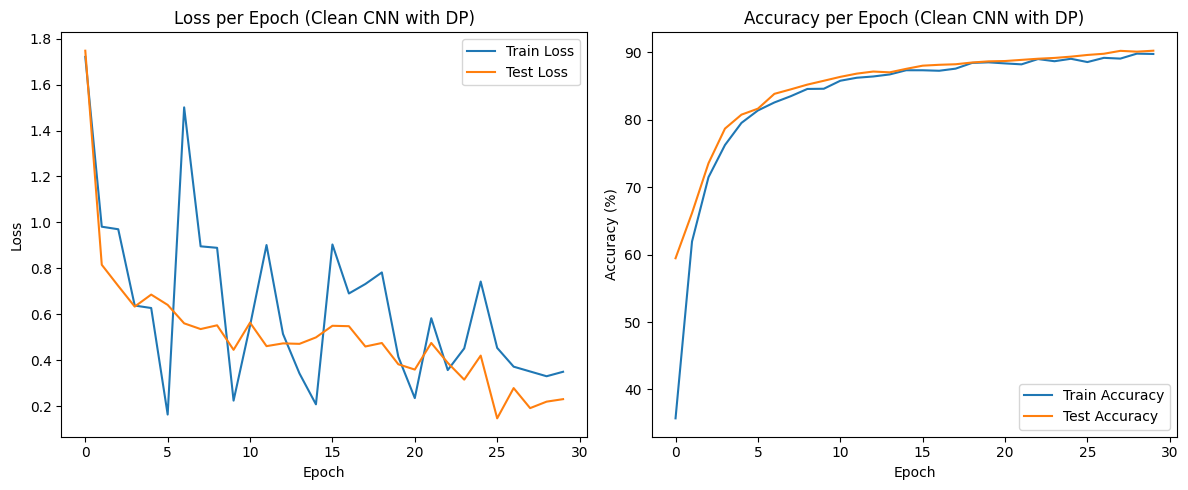

In [6]:
def compute_accuracy(correct_list, total_samples):
    return [100 * (x / total_samples) for x in correct_list]

train_acc = compute_accuracy(train_correct, len(trainLoader.dataset))
test_acc = compute_accuracy(test_correct, len(testLoader.dataset))

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss per Epoch (Clean CNN with DP)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy per Epoch (Clean CNN with DP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()